<a href="https://colab.research.google.com/github/light-y44/NeuralNet_Practice_AndrejK/blob/main/NeuralNet_library.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [97]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
      self.data = data
      self._children = _children
      self._op = _op
      self.label = label
      self.grad = 0.0 # Gradient is initialised to 0.0
      self._backward = lambda: None # Here, the "backward" method calculates the backpropagation.

    def __repr__(self):
      return f"Value(data={self.data})"

    # def __eq__(self, other):
    #   return id(self) == id(other)

    # def __hash__(self):
    #   return id(self)

    def __add__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data + other.data, (self, other), '+', f'{self.label} + {other.label}')

      def _backward():
        self.grad += 1.0 * out.grad # chain rule => dl/dout*dout/dx
        other.grad += 1.0 * out.grad
      out._backward = _backward

      return out

    def __radd__(self, other): # fall back operation, in case we have 2*a, then we wouldn't know how to perform addition of a scalar and Value
      return self + other

    def __neg__(self):
      return self * -1

    def __sub__(self, other):
      return self + (-other)

    def __rsub__(self, other):
      return other + (-self)

    def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'**{other}', f'{self.label}**{other}')
      def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
      out._backward = _backward
      return out

    def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out =  Value(self.data * other.data, (self, other), '*', f'{self.label} * {other.label}')

      def _backward():
        self.grad += other.data * out.grad # chain rule => dl/dout*dout/dx
        other.grad += self.data * out.grad
      out._backward = _backward

      return out

    def __rmul__(self, other):   # fall back operation, in case we have 2*a, then we wouldn't know how to perform multiplication of a scalar and Value
      return self * other

    def __truediv__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data**-1, (self, other), '/', f'{self.label} / {other.label}')
      def _backward():
        self.grad += other.data**-1 * out.grad
        other.grad += -other.data**-2 * self.data * out.grad
      out._backward = _backward
      return out

    def tanh(self):
      x = self.data
      t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1) # out = tanh(x)
      out = Value(t, (self, ), 'tanh', f'tanh({self.label})')

      def _backward():
        self.grad += (1 - t**2) * out.grad #chain rule => dl/dout*dout/dx => out.grad*dout/dx
      out._backward = _backward

      return out

    # One pass of back propagation
    def Backward(self):
      topo = []
      visited = set()
      def build_topo(v):
        if v not in visited:
          visited.add(v)
          for child in v._children:
            build_topo(child)
          topo.append(v)

      build_topo(self)

      self.grad = 1.0
      for node in reversed(topo):
        node._backward()

In [91]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape = 'record')
    if n._op:
      dot.node(name = uid + n._op, label = n._op)
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot



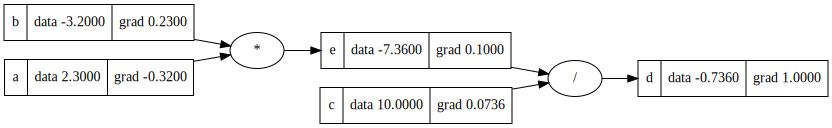

In [57]:
a = Value(2.3, label='a')
b = Value(-3.2, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e/c; d.label = 'd'

d.Backward()
draw_dot(d)



In [115]:
import random

class Neuron:
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    out = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    return out.tanh()

  def parameters(self):
    return self.w + [self.b]


In [120]:
class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

In [121]:
class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [122]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0]
ypred = [n(x) for x in xs]

In [127]:
# Training
epochs = 50
alpha = 0.05
n = MLP(3, [4, 4, 1])
for k in range(epochs):
  ypred = [n(x) for x in xs]
  loss = sum((ygt - yout)**2 for ygt, yout in zip(ys, ypred))
  loss.Backward()
  for p in n.parameters():
    p.data = p.data - alpha * p.grad
    p.grad = 0.0
    '''Setting grad to 0 because in the next time step we would want to calculate the gradient again
    however in the code we use += instead of = hence if we don't set it to 0 we would keep adding to the already existing grad.'''
  print(k, loss.data)

0 4.058565190335073
1 2.624539444245687
2 1.9909930408780951
3 1.5953626857505272
4 1.2034652125479695
5 0.8718748818144211
6 0.6297138487489016
7 0.4655049235546347
8 0.3558482253197289
9 0.28122570669072144
10 0.22881638891001554
11 0.1907640948026089
12 0.16227430476704663
13 0.1403593680089033
14 0.12310285042370411
15 0.10923771749481367
16 0.0979017962674293
17 0.08849268418271716
18 0.08057930172687969
19 0.07384647809443591
20 0.06805931028117604
21 0.0630396717104739
22 0.05865037515070629
23 0.05478427245094815
24 0.05135660857550922
25 0.04829956448505644
26 0.045558299836532715
27 0.043088041117353267
28 0.040851910087349085
29 0.03881928415947933
30 0.036964544190399753
31 0.035266107971363016
32 0.03370567687356692
33 0.03226764325092231
34 0.03093862031091786
35 0.02970706616618542
36 0.028562980953820892
37 0.027497661112523806
38 0.02650349871998573
39 0.02557381661355551
40 0.02470273212317793
41 0.02388504383160672
42 0.02311613698105845
43 0.022391904066804257
44 0.

In [128]:
ypred = [n(x) for x in xs]
ypred # The values are very close to the y ground truth

[Value(data=0.9059885857667951),
 Value(data=-0.9463037534741189),
 Value(data=-0.9188429712641684),
 Value(data=0.8778204334391946)]